In [189]:
from imblearn.ensemble import BalancedRandomForestClassifier
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [95]:
features = pd.read_pickle("train_features.pkl")
labels = pd.read_csv("train_labels.csv",index_col="challenge_oid")
features.index.name = "challenge_oid"
features = features.join(labels)

In [96]:
labels = features["classALeRCE"]
del features["classALeRCE"] 

In [97]:
periodic = ["RRL", "EB", "DSCT", "Ceph", "Periodic-Other"]
stochastic = ["AGN", "QSO", "YSO", "CV/Nova", "LPV", "Blazar"]
transient = ["SNIa", "SNII", "SNIbc"]

In [77]:
def map_class(x):
    class_map = {"periodic": periodic, "stochastic": stochastic, "transient": transient}
    for i in class_map:
        if x in class_map[i]:
            return i

In [80]:
new_classes = []
for old_class in labels.values:
    new_classes.append(map_class(old_class))

In [81]:
root_le = LabelEncoder()
new_classes_encoded = root_le.fit_transform(new_classes)

In [82]:
n_trees = 1000

In [191]:
root = BalancedRandomForestClassifier(n_estimators=n_trees)
fe = RFE(root,5, step=1)

In [84]:
fpreproces = features.replace(np.nan,-999)
fpreproces = fpreproces.replace(np.infty, -999)
fpreproces = fpreproces.replace(-np.infty,-999)

BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                criterion='gini', max_depth=None, max_features='auto',
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                min_samples_leaf=2, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
                oob_score=False, random_state=None, replacement=False,
                sampling_strategy='auto', verbose=0, warm_start=False)

In [193]:
root.fit(fpreproces,new_classes_encoded)

BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                criterion='gini', max_depth=None, max_features='auto',
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                min_samples_leaf=2, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
                oob_score=False, random_state=None, replacement=False,
                sampling_strategy='auto', verbose=0, warm_start=False)

In [110]:
transient_tree = BalancedRandomForestClassifier(n_estimators=n_trees)
transient_le = LabelEncoder()
transient_objects = fpreproces[labels.isin(transient)]
transient_labels = transient_le.fit_transform(labels[labels.isin(transient)])
transient_tree.fit(transient_objects,transient_labels)

BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                criterion='gini', max_depth=None, max_features='auto',
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                min_samples_leaf=2, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
                oob_score=False, random_state=None, replacement=False,
                sampling_strategy='auto', verbose=0, warm_start=False)

In [111]:
stochastic_tree = BalancedRandomForestClassifier(n_estimators=n_trees)
stochastic_le = LabelEncoder()
stochastic_objects = fpreproces[labels.isin(stochastic)]
stochastic_labels = stochastic_le.fit_transform(labels[labels.isin(stochastic)])
stochastic_tree.fit(stochastic_objects,stochastic_labels)

BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                criterion='gini', max_depth=None, max_features='auto',
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                min_samples_leaf=2, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
                oob_score=False, random_state=None, replacement=False,
                sampling_strategy='auto', verbose=0, warm_start=False)

In [112]:
periodic_tree = BalancedRandomForestClassifier(n_estimators=n_trees)
periodic_le = LabelEncoder()
periodic_objects = fpreproces[labels.isin(periodic)]
periodic_labels = periodic_le.fit_transform(labels[labels.isin(periodic)])
periodic_tree.fit(periodic_objects,periodic_labels)

BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                criterion='gini', max_depth=None, max_features='auto',
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                min_samples_leaf=2, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
                oob_score=False, random_state=None, replacement=False,
                sampling_strategy='auto', verbose=0, warm_start=False)

In [104]:
features_test = pd.read_pickle("test_features.pkl")
features_test = features_test.replace(np.nan, -999)
features_test = features_test.replace(np.infty,-999)
features_test = features_test.replace(-np.infty,-999)
root_probs = root.predict_proba(features_test)

In [106]:
transient_probs = transient_tree.predict_proba(features_test)
stochastic_probs = stochastic_tree.predict_proba(features_test)
periodic_probs = periodic_tree.predict_proba(features_test)

In [115]:
root_probs = pd.DataFrame(root_probs,columns=root_le.classes_)

In [143]:
t = pd.DataFrame(np.multiply(transient_probs, root_probs.transient.values[:,np.newaxis]), columns=transient_le.classes_)

In [145]:
p = pd.DataFrame(np.multiply(periodic_probs, root_probs.periodic.values[:,np.newaxis]), columns=periodic_le.classes_)

In [148]:
s = pd.DataFrame(np.multiply(stochastic_probs, root_probs.stochastic.values[:,np.newaxis]), columns=stochastic_le.classes_)

In [151]:
new_classes = t.join(p).join(s)

In [153]:
new_classes.index = features_test.index

In [157]:
new_classes["Outlier"] = 0

In [159]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [202]:
new_classes.to_csv("hierarchical_rf.csv")

In [201]:
new_classes.index.name = "challenge_oid"

In [174]:
classes = new_classes.idxmax(axis=1)

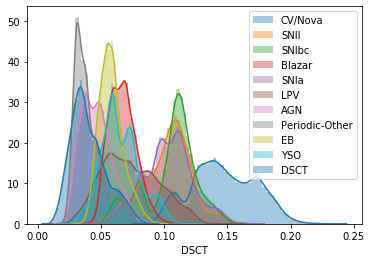

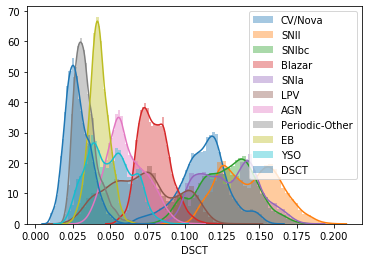

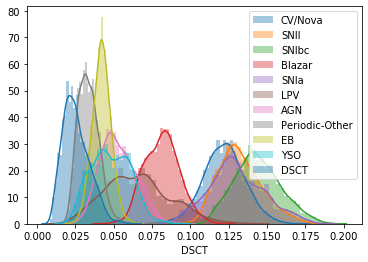

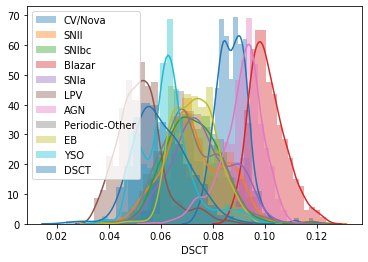

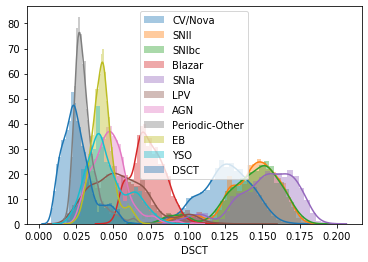

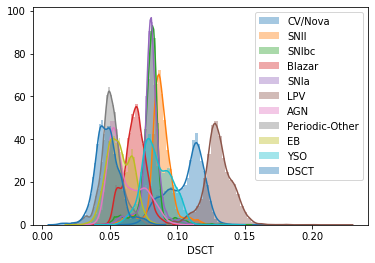

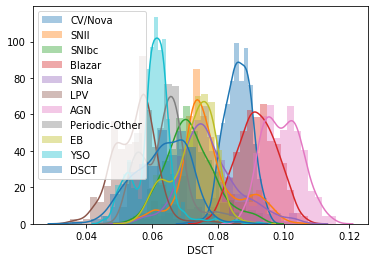

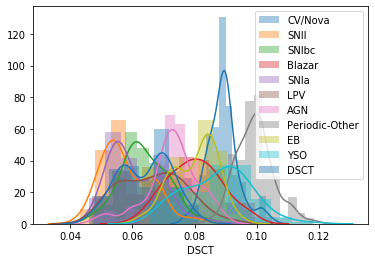

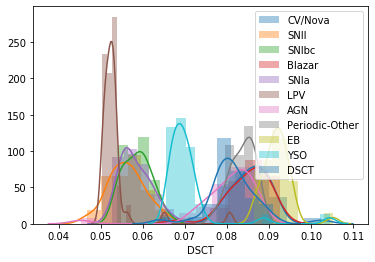

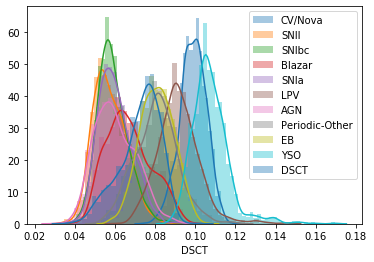

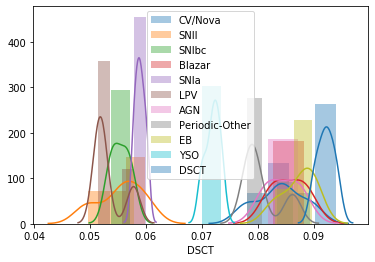

In [185]:
for c in classes.unique():
    fig, ax = plt.subplots(1,1)
    for cj in classes.unique():
        sns.distplot(new_classes[classes == c][cj],ax=ax,label=cj)
    ax.set_xlabel()
    ax.legend()
    plt.show()

In [187]:
list(features.columns)

['Amplitude_1',
 'Amplitude_2',
 'AndersonDarling_1',
 'AndersonDarling_2',
 'Autocor_length_1',
 'Autocor_length_2',
 'Beyond1Std_1',
 'Beyond1Std_2',
 'Con_1',
 'Con_2',
 'Eta_e_1',
 'Eta_e_2',
 'ExcessVar_1',
 'ExcessVar_2',
 'GP_DRW_sigma_1',
 'GP_DRW_sigma_2',
 'GP_DRW_tau_1',
 'GP_DRW_tau_2',
 'Gskew_1',
 'Gskew_2',
 'Harmonics_mag_1_1',
 'Harmonics_mag_1_2',
 'Harmonics_mag_2_1',
 'Harmonics_mag_2_2',
 'Harmonics_mag_3_1',
 'Harmonics_mag_3_2',
 'Harmonics_mag_4_1',
 'Harmonics_mag_4_2',
 'Harmonics_mag_5_1',
 'Harmonics_mag_5_2',
 'Harmonics_mag_6_1',
 'Harmonics_mag_6_2',
 'Harmonics_mag_7_1',
 'Harmonics_mag_7_2',
 'Harmonics_mse_1',
 'Harmonics_mse_2',
 'Harmonics_phase_2_1',
 'Harmonics_phase_2_2',
 'Harmonics_phase_3_1',
 'Harmonics_phase_3_2',
 'Harmonics_phase_4_1',
 'Harmonics_phase_4_2',
 'Harmonics_phase_5_1',
 'Harmonics_phase_5_2',
 'Harmonics_phase_6_1',
 'Harmonics_phase_6_2',
 'Harmonics_phase_7_1',
 'Harmonics_phase_7_2',
 'IAR_phi_1',
 'IAR_phi_2',
 'LinearTren

In [ ]:
transient_tree.